# Table of contents:

1. How to Construct Block Encodings
    1. The LCU Approach
    2. Matrix Access Oracle Approach
        1. Block Encoding structured matrices
        2. Block Encoding sparse matrices
    3. Using BlockEncode defined function Approach
    4. Manual Block Encoding with Qiskit Approach

In [ ]:
import numpy as np
import pennylane as qml
from IPython.display import Image, display
import matplotlib.pyplot as plt
from pennylane.templates.state_preparations.mottonen import compute_theta, gray_code


from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector
from scipy.linalg import svd, sqrtm

C:\Users\CristinaÁlvarezYuste\AppData\Local\Temp\ipykernel_19468\1802262779.py:11: DeprecationWarning: Using Qiskit with Python 3.9 is deprecated as of the 2.1.0 release. Support for running Qiskit with Python 3.9 will be removed in the 2.3.0 release, which coincides with when Python 3.9 goes end of life.
  from qiskit import QuantumCircuit


# 1. How to Construct Block Encodings

There are multiple strategies to construct block encodings.  
In this notebook, we restrict attention to **Hermitian matrices $A$**.  

The key challenge is embedding a (generally non-unitary) matrix into the top-left block of a larger unitary:
$$
U_A = 
\begin{pmatrix}
A / \alpha & * \\
* & *
\end{pmatrix},
$$
with normalization factor $\alpha \geq \|A\|$.

The subsections are:

- **Sec. 1.1–1.2 (Realistic operators):**  
  Large, sparse, or structured matrices → oracle-based methods such as **LCU** and **FABLE** (PennyLane based).

- **Sec. 1.3 (Pedagogical cases):**  
  Small toy matrices → direct **block completion**, mainly for intuition.



---

## 1.1 The LCU Approach

The **Linear Combination of Unitaries** method expresses a target operator $ A $ as a weighted sum of unitaries:
$$
A = \sum_{k=0}^{N-1} \alpha_k U_k,
$$
where the $ U_k $ are unitaries and the $ \alpha_k $ are complex coefficients with known normalization.

A key fact:  
The **Pauli basis** forms a complete operator basis for qubits. Every operator $A$ acting on $n$ qubits can be expanded as
$$
A = \sum_P c_P P,
$$
where $P$ ranges over tensor products of Pauli matrices $\{I, X, Y, Z\}^{\otimes n}$.  
This automatically provides an LCU decomposition, since each Pauli operator $ P $ is unitary.

Therefore, one way to construct a block encoding of \(A\) is:
- Express \(A\) in the Pauli basis.  
- Factor the coefficients \(c_P\) into probabilities and phases.  
- Implement a **select** oracle that applies \(P\) conditioned on an index register.  
- Use **amplitude amplification** (or related techniques) to boost the success probability and normalize by \(\sum |c_P|\).


In [2]:
# Example matrix 1 (must be Hermitian for this method)
a = 0.25
b = 0.75
A1 = np.array(
    [[a,  0, 0,  b],
     [0, -a, b,  0],
     [0,  b, a,  0],
     [b,  0, 0, -a]])                      

LCU = qml.pauli_decompose(A1)   #based on vectorizing the matrix and exploiting properties of the Walsh-Hadamard transform (cost scales as ~O(n 4^n) for n qubits)
LCU_coeffs, LCU_ops = LCU.terms()

print(f"LCU decomposition:\n {LCU}")
print(f"Coefficients:\n {LCU_coeffs}")
print(f"Unitaries:\n {LCU_ops}")

LCU decomposition:
 0.25 * (I(0) @ Z(1)) + 0.75 * (X(0) @ X(1))
Coefficients:
 [0.25 0.75]
Unitaries:
 [I(0) @ Z(1), X(0) @ X(1)]


### From LCU to a Quantum Circuit

An LCU decomposition can be turned into a quantum circuit using three standard steps: **prepare, select, unprepare**.

- **PREP operator:** Prepares a superposition of indices with amplitudes proportional to the coefficients  
  $$
  \text{PREP}\,|0\rangle = \sum_k \sqrt{\tfrac{\alpha_k}{\lambda}}\,|k\rangle,
  $$
  where $\lambda = \sum_k |\alpha_k|$.

- **SEL operator:** Applies the corresponding unitary conditioned on the index register  
  $$
  \text{SEL}\,|k\rangle|\psi\rangle = |k\rangle U_k|\psi\rangle.
  $$

- **UNPREP operator:** Applies $\text{PREP}^\dagger$ to “uncompute” the index register.


Putting it together, we define the circuit
$$
U = \text{PREP}^\dagger \cdot \text{SEL} \cdot \text{PREP},
$$
which realizes the block encoding of $A$ up to normalization by $\lambda$:
$$
\langle 0|\,U\,|0\rangle|\psi\rangle
= \langle 0|\,\text{PREP}^\dagger \cdot \text{SEL} \cdot \text{PREP}\,|0\rangle|\psi\rangle
= \tfrac{A}{\lambda}\,|\psi\rangle.
$$

If we measure the ancilla qubits in the $|0\rangle$ state, the input state $|\psi\rangle$ is transformed by $A/\lambda$ (up to normalization).  

In [3]:
display(Image(url="https://blog-assets.cloud.pennylane.ai/demos/tutorial_lcu_blockencoding/main/_assets/static/demonstration_assets/lcu_blockencoding/schematic.png?w=1920"))

Target state:  [0.5       0.8660254]
Output state:  [0.5       0.8660254]


Matplotlib is building the font cache; this may take a moment.


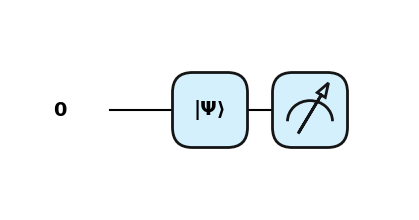

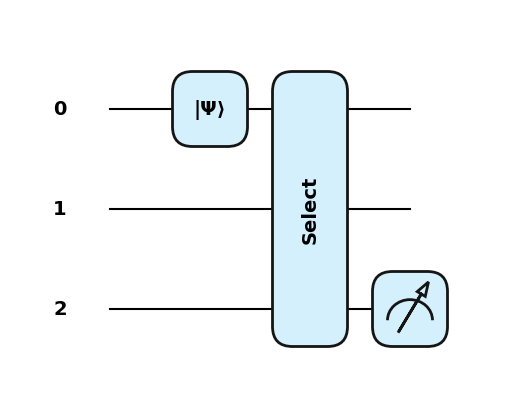

In [4]:
# Create the backend suitable for the circuits (1 qubit statevector simulator)
dev1 = qml.device("default.qubit", wires=1) 

# Normalized square roots of coefficients
alphas = (np.sqrt(LCU_coeffs) / np.linalg.norm(np.sqrt(LCU_coeffs)))

@qml.qnode(dev1)                      # Creates a function that runs on the device 'dev1'
def prep_circuit():
    qml.StatePrep(alphas, wires=0)    # PREP operator: loads the state amplitudes on qubit 0 (PREP|0> = sum_k sqrt(alpha_k/lambda) |k>)
    return qml.state()                # Returns the quantum state, for the 1 qubit case this is: alpha_0 |0> + alpha_1 |1> 

print("Target state: ", alphas)
print("Output state: ", np.real(prep_circuit()))  #np.real to avoid small imaginary parts due to numerical errors
qml.draw_mpl(prep_circuit, style='pennylane')()
plt.show()

# Create the backend suitable for the circuits (3 qubit statevector simulator)
# Wire 0 is the control qubit, and wires 1 and 2 are the target qubits
dev2 = qml.device("default.qubit", wires=3)

# List of unitaries (originally acting on wires 0 and 1)
ops = LCU_ops
unitaries = [qml.map_wires(op, {0: 1, 1: 2}) for op in ops] # relabeling wires: 0 → 1, and 1 → 2

@qml.qnode(dev2)                            # Creates a function that runs on the device 'dev2' 
def sel_circuit(qubit_value):               # qubit_value = 0 or 1
    qml.BasisState(qubit_value, wires=0)    # Initializes the control qubit (wire 0) in |0> or |1>
    qml.Select(unitaries, control=0)        # SEL operator: takes the target unitaries as input (SEL|k>|psi> = |k> U_k |psi>)
    return qml.expval(qml.PauliZ(2))        # Measures the expectation value of Z on qubit 2 

qml.draw_mpl(sel_circuit, style='pennylane')([0])
plt.show()

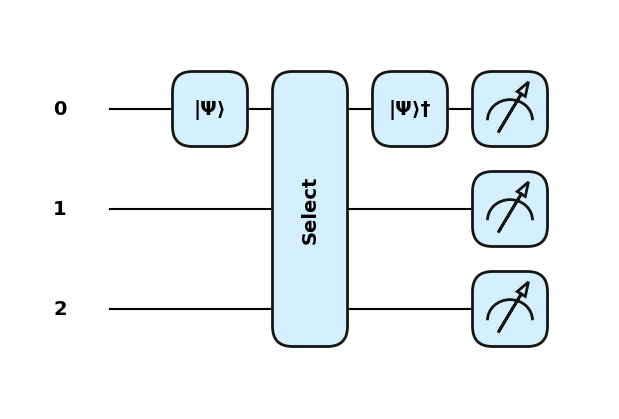

A:
 [[ 0.25  0.    0.    0.75]
 [ 0.   -0.25  0.75  0.  ]
 [ 0.    0.75  0.25  0.  ]
 [ 0.75  0.    0.   -0.25]] 



Block-encoded A1:
 [[ 0.25  0.    0.    0.75 -0.43  0.    0.    0.43]
 [ 0.   -0.25  0.75  0.    0.    0.43  0.43  0.  ]
 [ 0.    0.75  0.25  0.    0.    0.43 -0.43  0.  ]
 [ 0.75  0.    0.   -0.25  0.43  0.    0.    0.43]
 [-0.43  0.    0.    0.43  0.75  0.    0.    0.25]
 [ 0.    0.43  0.43  0.    0.   -0.75  0.25  0.  ]
 [ 0.    0.43 -0.43  0.    0.    0.25  0.75  0.  ]
 [ 0.43  0.    0.    0.43  0.25  0.    0.   -0.75]]


In [5]:
@qml.qnode(dev2)                                 # Creates a function that runs on the device 'dev2'
def lcu_circuit():                               # Block-encoding circuit
    # PREP
    qml.StatePrep(alphas, wires=0)               # Applied to ancilla register qubit 0

    # SEL
    qml.Select(unitaries, control=0)             # Applied to target register qubits 1 and 2 conditioned on ancilla qubit 0

    # PREP_dagger
    qml.adjoint(qml.StatePrep(alphas, wires=0))  # Applied to ancilla register qubit 0
    return qml.state()                           # Returns the quantum state of the 3 qubits

qml.draw_mpl(lcu_circuit, style='pennylane')()
plt.show()

output_matrix = qml.matrix(lcu_circuit)()
print("A:\n", A1, "\n")
print("\n\nBlock-encoded A1:\n",np.real(np.round(output_matrix,2)))


---

## 1.2 Matrix Access Oracle Approach

Another way to construct a block encoding of an $N \times N$ matrix $A$ (with $N=2^n$) is through **matrix access oracles**.  
A general circuit can be built if we assume access to two black-box unitaries, $U_A$ and $U_B$ (see figure below):

- **$H^n$**: a Hadamard transformation on $n$ qubits.  
- **$U_A$**: encodes matrix entries $A_{i,j}$ into the amplitude of an ancilla qubit.  
- **$U_B$**: ensures iteration over every pair $(i,j)$.

In [6]:
display(Image(url="https://blog-assets.cloud.pennylane.ai/demos/tutorial_block_encoding/main/_assets/static/demonstration_assets/block_encoding/general_circuit.png?w=1920"))

Finding an optimal quantum gate decomposition that implements $U_A$ and $U_B$ is not always possible. We now explore two different approaches for constructing these oracles that can be very efficient for matrices with specific structure or sparsity.

### 1.2.1 Block encoding structured matrices

To better understand this framework, let us define $U_A$ and $U_B$ for the *exact* block encoding of $A$:

- **$U_A$ oracle:** encodes the value of $A_{i,j}$ into an auxiliary qubit
  $$
  U_A \,|0\rangle_{\text{anc}} |i\rangle |j\rangle
  = |A_{i,j}\rangle_{\text{anc}} |i\rangle |j\rangle,
  $$
  with
  $$
  |A_{i,j}\rangle_{\text{anc}}
  \equiv A_{i,j}\,|0\rangle_{\text{anc}}
  + \sqrt{\,1 - |A_{i,j}|^2\,}\,|1\rangle_{\text{anc}}.
  $$

- **$U_B$ oracle:** swaps the indices to cover all pairs $(i,j)$
  $$
  U_B \,|i\rangle |j\rangle = |j\rangle |i\rangle.
  $$

A straightforward construction of $U_A$ uses a sequence of **multi-controlled rotations** with angles determined by the entries $A_{i,j}$ but this requires $\mathcal{O}(N^4)$ gates, and quickly becomes inefficient.  

A more scalable alternative is **FABLE (Fast Approximate Block Encoding)** which leverages the oracle access model together with approximations (tunable) that trade off circuit depth for accuracy.  

The FABLE circuit is built from single-qubit rotations and CNOT gates:

- Multi-controlled rotations are avoided by a **special angle transformation**.  
- The required rotation angles $\theta$ are derived from the matrix entries via a transformation matrix $M$:
  $$
  \begin{pmatrix}
  \theta_1 \\
  ... \\
  \theta_n
  \end{pmatrix}
  = M 
  \begin{pmatrix}
  \alpha_1 \\
  ... \\
  \alpha_n
  \end{pmatrix}
  $$
- In PennyLane, these angles can be computed with `compute_theta()`.


In [7]:
# Example matrix 2 (doesnt have to be Hermitian for this method since FABLE only requires that you can encode matrix entries into angles for rotations)
A2 = np.array([[-0.51192128, -0.51192128,  0.6237114 ,  0.6237114 ],
              [ 0.97041007,  0.97041007,  0.99999329,  0.99999329],
              [ 0.82429855,  0.82429855,  0.98175843,  0.98175843],
              [ 0.99675093,  0.99675093,  0.83514837,  0.83514837]])

# The arccos mapping is used because a single-qubit rotation R_y(θ) |0⟩ = cos(θ/2)|0⟩ + sin(θ/2)|1⟩ can encode any value in [0,1]
alphas = np.arccos(A2).flatten() 
thetas = compute_theta(alphas)

We use three registers:

- **ancilla**: a single qubit (the auxiliary qubit where we apply the rotations).
- **wires_i**: an $n$-qubit register that indexes the row $i$.
- **wires_j**: an $n$-qubit register that indexes the column $j$.


This layout supports oracles of the form:
$$
U_A\,|0\rangle_{\text{anc}}\,|i\rangle\,|j\rangle
= |A_{i,j}\rangle_{\text{anc}}\,|i\rangle\,|j\rangle,
\qquad
U_B\,|i\rangle\,|j\rangle = |j\rangle\,|i\rangle,
$$
with $|i\rangle$ and $|j\rangle$ encoded on the $n$-qubit registers.


In [8]:
# 1 qubit
ancilla_wires = ["ancilla"]

s = int(np.log2(A2.shape[0]))                   # log2 of the number of rows/columns of A2
wires_i = [f"i{index}" for index in range(s)]   # ['i0', 'i1'] for s=2
wires_j = [f"j{index}" for index in range(s)]   # ['j0', 'j1'] for s=2

# Then obtain the control wires for the C-NOT gates and a wire map that we later use to translate the control wires into the wire registers we prepared.
code = gray_code(int(2 * np.log2(len(A2))))     # Ordering of binary strings
print("Gray code: ", code)                      # ['0000', '0001', '0011', '0010', '0110', '0111', '0101', '0100', '1100', '1101', '1111', '1110', '1010', '1011', '1001', '1000']

### Gray code as integers
def gray_code(n):
    return np.array([i ^ (i >> 1) for i in range(2**n)], dtype=int)
code = gray_code(int(2 * np.log2(len(A2))))
print("Gray code (int):", code)                 # [ 0  1  3  2  6  7  5  4 12 13 15 14 10 11  9  8]
###

control_wires = np.log2(code ^ np.roll(code, -1)).astype(int) # Identify which bit flips (CNOT is applied on these wires)
print("Control wire indices:", control_wires)

# Map bit indices to actual wire labels
wire_map = {control_index : wire for control_index, wire in enumerate(wires_j + wires_i)}

Gray code:  ['0000', '0001', '0011', '0010', '0110', '0111', '0101', '0100', '1100', '1101', '1111', '1110', '1010', '1011', '1001', '1000']
Gray code (int): [ 0  1  3  2  6  7  5  4 12 13 15 14 10 11  9  8]
Control wire indices: [0 1 0 2 0 1 0 3 0 1 0 2 0 1 0 3]


We now construct the $U_A$ and $U_B$ oracles as well as the operator representing the tensor product of Hadamard gates.

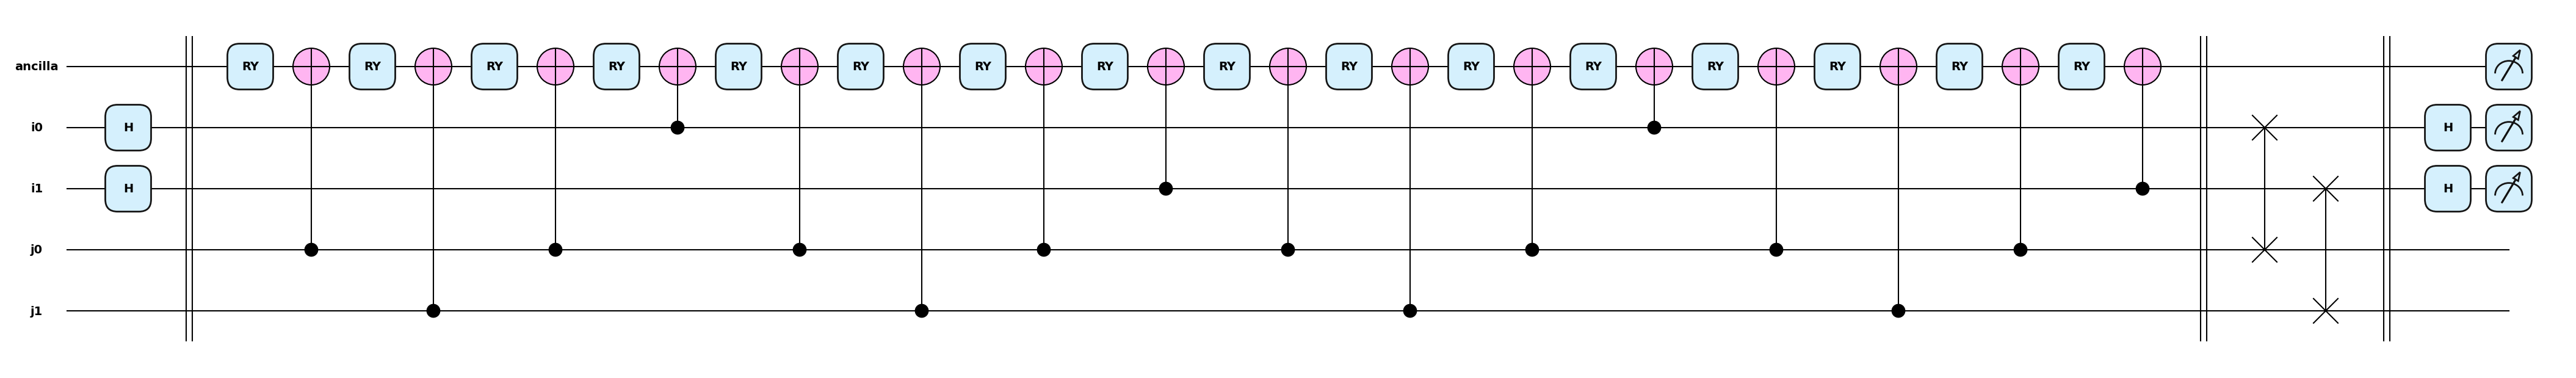

In [9]:
def UA(thetas, control_wires, ancilla):                                       # Apply the sequence of controlled rotations and C-NOT gates
    for theta, control_index in zip(thetas, control_wires):
        qml.RY(2 * theta, wires=ancilla)
        qml.CNOT(wires=[wire_map[control_index]] + ancilla)


def UB(wires_i, wires_j):                                                     # Swap the two registers
    for w_i, w_j in zip(wires_i, wires_j):
        qml.SWAP(wires=[w_i, w_j])


def HN(input_wires):                                                          # Apply Hadamard to all qubits in input_wires 
    for w in input_wires:
        qml.Hadamard(wires=w)

      
dev = qml.device('default.qubit', wires=ancilla_wires + wires_i + wires_j)    # We construct the circuit using these oracles and draw it.
@qml.qnode(dev)                                                               # Creates a function that runs on the device 'dev'
def circuit():
    HN(wires_i)
    qml.Barrier()                                                             # To separate the sections in the circuit
    UA(thetas, control_wires, ancilla_wires)
    qml.Barrier()
    UB(wires_i, wires_j)
    qml.Barrier()
    HN(wires_i)
    return qml.probs(wires=ancilla_wires + wires_i)

qml.draw_mpl(circuit, style='pennylane')()
plt.show()

In [10]:
# Finally, we compute the matrix representation of the circuit and print its top-left block to compare it with the original matrix.

print(f"Original matrix:\n{A2}", "\n")
wire_order = ancilla_wires + wires_i[::-1] + wires_j[::-1]
U = qml.matrix(circuit, wire_order=wire_order)().real
print(f"Full unitary:\n{U}","\n")
M = len(A2) * qml.matrix(circuit, wire_order=wire_order)().real[0:len(A2),0:len(A2)]
print(f"Block-encoded submatrix multiplied by the normalization constant: \n{M}", "\n")

Original matrix:
[[-0.51192128 -0.51192128  0.6237114   0.6237114 ]
 [ 0.97041007  0.97041007  0.99999329  0.99999329]
 [ 0.82429855  0.82429855  0.98175843  0.98175843]
 [ 0.99675093  0.99675093  0.83514837  0.83514837]] 

Full unitary:
[[-0.12798032 -0.12798032  0.15592785 ... -0.21475809 -0.19541368
  -0.19541368]
 [ 0.24260252  0.24260252  0.24999832 ...  0.06036571  0.00091583
   0.00091583]
 [ 0.20607464  0.20607464  0.24543961 ...  0.14153884  0.04753314
   0.04753314]
 ...
 [ 0.06036571 -0.06036571 -0.00091583 ...  0.24260252  0.24999832
  -0.24999832]
 [ 0.14153884 -0.14153884 -0.04753314 ...  0.20607464  0.24543961
  -0.24543961]
 [ 0.02013638 -0.02013638 -0.13750618 ... -0.24918773 -0.20878709
   0.20878709]] 

Block-encoded submatrix multiplied by the normalization constant: 
[[-0.51192128 -0.51192128  0.6237114   0.6237114 ]
 [ 0.97041007  0.97041007  0.99999329  0.99999329]
 [ 0.82429855  0.82429855  0.98175843  0.98175843]
 [ 0.99675093  0.99675093  0.83514837  0.8351483


One of the key ideas behind the **FABLE** method is that quantum circuits can be **compressed** by eliminating operations that have little to no effect on the final result.

1. **Remove small-angle rotations**  
   Rotation gates with angles below a chosen threshold can be discarded without
   significantly affecting the computation.  

2. **Cancel redundant CNOTs**  
   After removing such rotations, the circuit mainly contains **CNOT gates**.  
   Since two consecutive CNOTs on the same wires cancel each other, many of
   these operations vanish as well.

In the example below a **tolerance of `0.01`** is setted to remove negligible rotations and CNOT gates are cancelled.

Because the original matrix is **highly structured**, many of its rotation angles are already zero. As a result, the **compressed circuit is equivalent to the original one**, while using fewer gates.


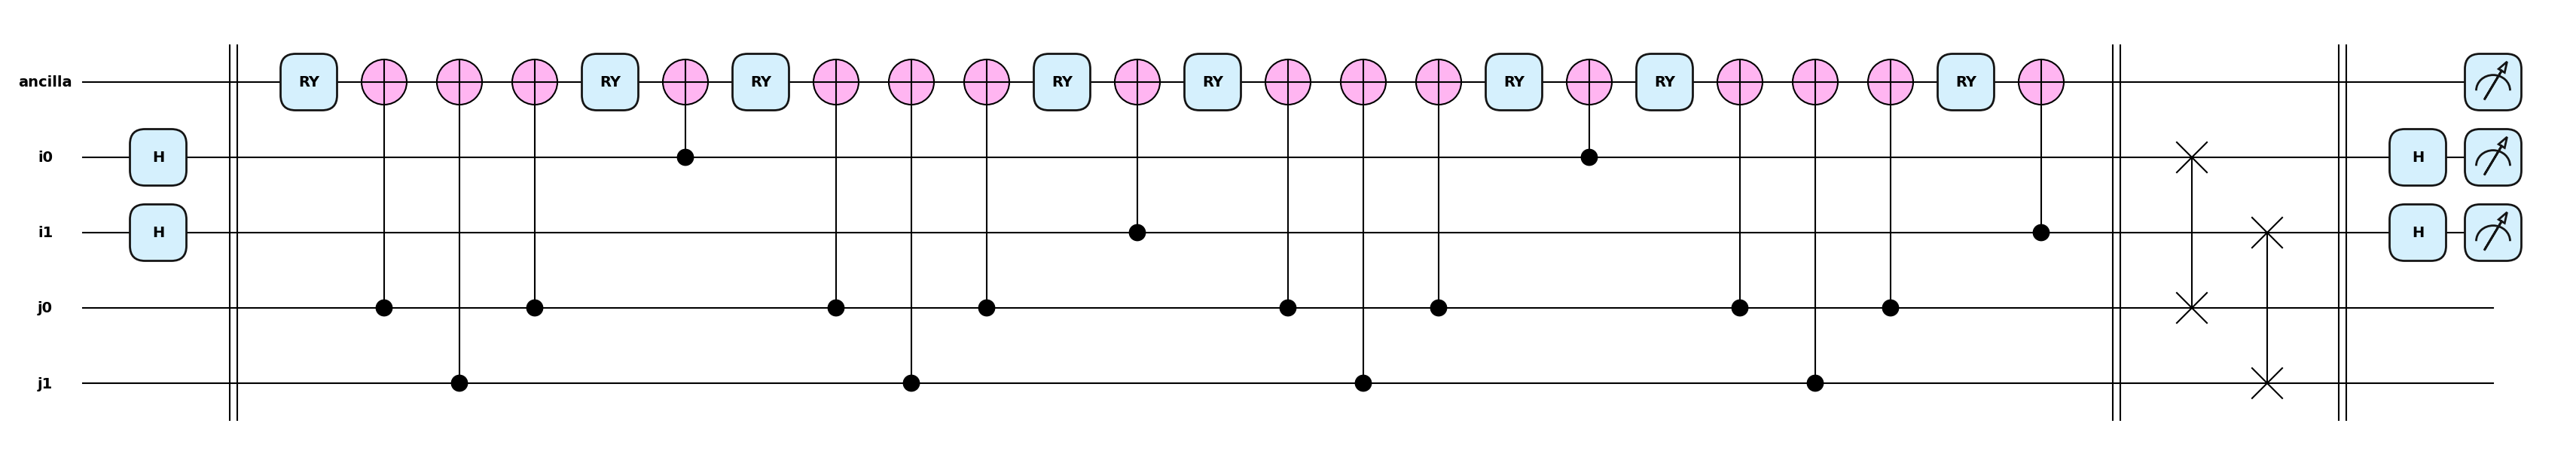

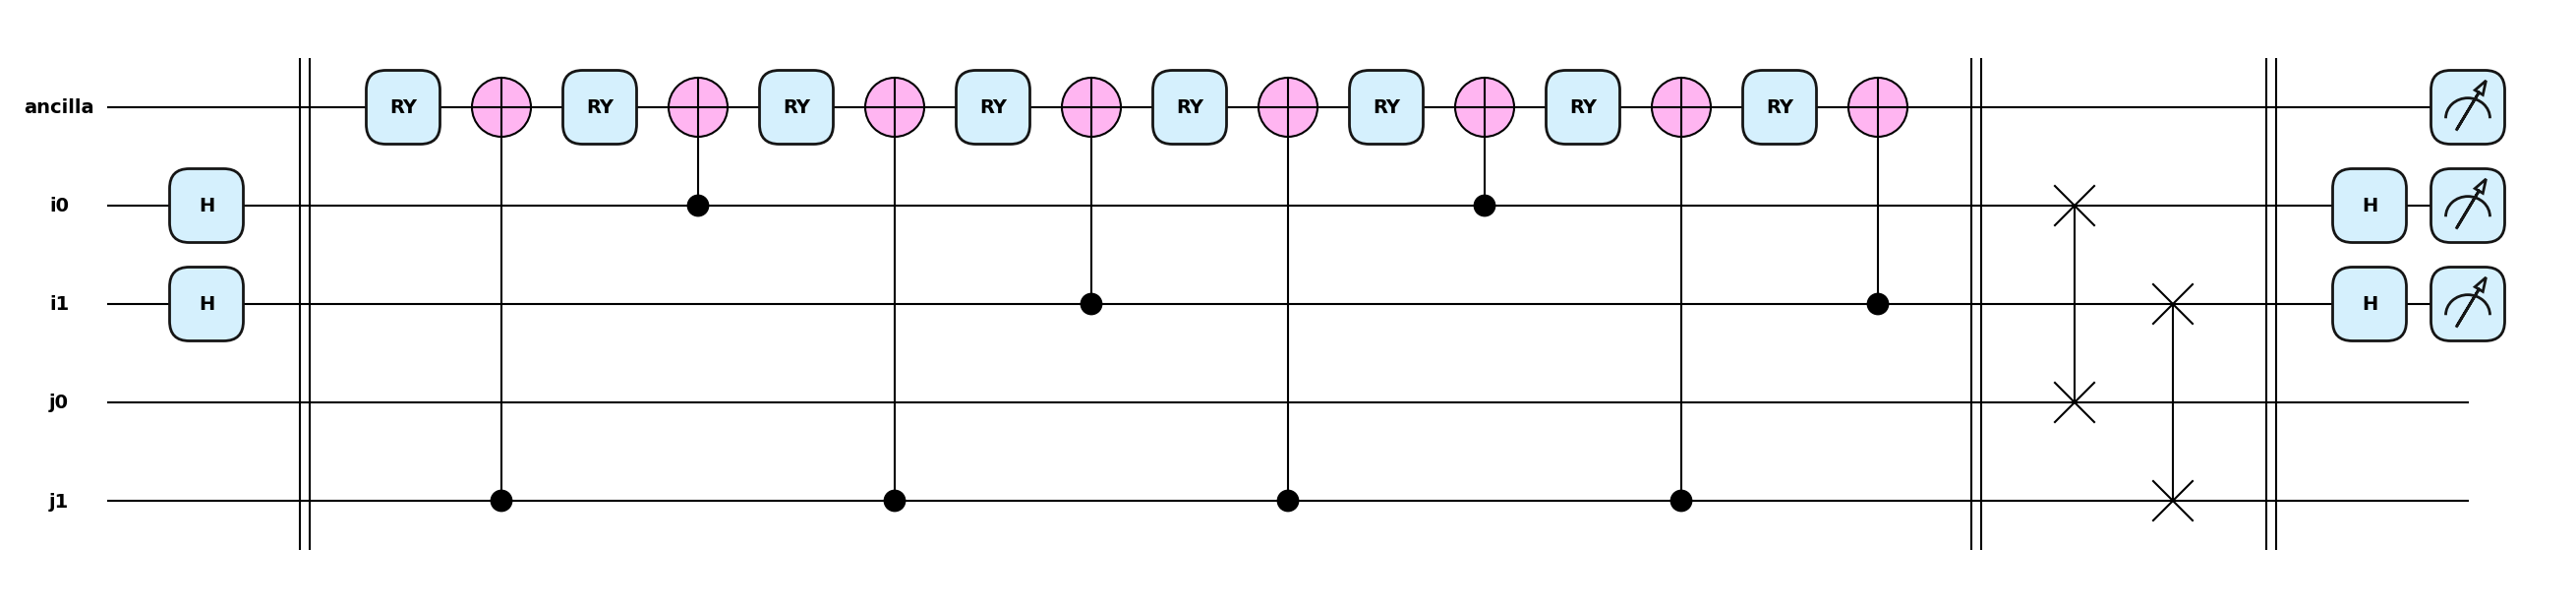

Original matrix:
[[-0.51192128 -0.51192128  0.6237114   0.6237114 ]
 [ 0.97041007  0.97041007  0.99999329  0.99999329]
 [ 0.82429855  0.82429855  0.98175843  0.98175843]
 [ 0.99675093  0.99675093  0.83514837  0.83514837]] 

Block-encoded matrix:
[[-0.51192128 -0.51192128  0.6237114   0.6237114 ]
 [ 0.97041007  0.97041007  0.99999329  0.99999329]
 [ 0.82429855  0.82429855  0.98175843  0.98175843]
 [ 0.99675093  0.99675093  0.83514837  0.83514837]] 



In [11]:
tolerance= 0.01

def UA(thetas, control_wires, ancilla):
    for theta, control_index in zip(thetas, control_wires):
        if abs(2 * theta)>tolerance:
            qml.RY(2 * theta, wires=ancilla)
        qml.CNOT(wires=[wire_map[control_index]] + ancilla)

qml.draw_mpl(circuit, style='pennylane')()
plt.show()

def UA(thetas, control_wires, ancilla):
    nots=[]
    for theta, control_index in zip(thetas, control_wires):
        if abs(2 * theta) > tolerance:
            for c_wire in nots:
                qml.CNOT(wires=[c_wire] + ancilla)
            qml.RY(2 * theta,wires=ancilla)
            nots=[]
        if (cw := wire_map[control_index]) in nots:
            del(nots[nots.index(cw)])
        else:
            nots.append(wire_map[control_index])
    for c_wire in nots:
        qml.CNOT([c_wire] + ancilla)

qml.draw_mpl(circuit, style='pennylane')()
plt.show()

print(f"Original matrix:\n{A2}", "\n")
wire_order = ancilla_wires + wires_i[::-1] + wires_j[::-1]
N = len(A2) * qml.matrix(circuit,wire_order=wire_order)().real[0:len(A2),0:len(A2)]
print(f"Block-encoded matrix:\n{N}", "\n")

### 1.2.2 Block Encoding sparse matrices

The quantum circuit for the oracle $U_A$, presented above, accesses every entry of $A$ and thus requires $O(N^2)$ gates to implement the oracle. In the special cases where $A$ is structured and sparse, we can generate a more efficient quantum circuit representation for $U_A$ and $U_B$ by only keeping track of the non-zero entries of the matrix.

Let $b(i, j)$ be a function such that it takes a column index $j$ and returns the row index for the $i^{\text{th}}$ non-zero entry in that column of $A$. Note, in this formulation, the $|i\rangle$ qubit register now refers to the number of non-zero entries in $A$. For sparse matrices, this can be much smaller than $N$, thus saving us many qubits. We use this to define $U_A$ and $U_B$.

- **$U_A$ oracle:** Like in the structured approach, the $U_A$ oracle is responsible for encoding the matrix entries of $A$ into the amplitude of the ancilla qubit. However, we now use $b(i, j)$ to access the row index of the non-zero entries:

$$
U_A |0\rangle_{\text{anc}} |i\rangle |j\rangle = |A_{b(i,j), j}\rangle_{\text{anc}} |i\rangle |j\rangle,
$$

- **$U_B$ oracle:** In this case the oracle is responsible for implementing the $b(i, j)$ function and taking us from the column index to the row index in the qubit register:

$$
U_B |i\rangle |j\rangle = |i\rangle |b(i, j)\rangle
$$


In [12]:
# Example matrix 3 (doesnt have to be Hermitian for this method)

alpha, beta, gamma  = 0.1, 0.6, 0.3
A3 = np.array([[alpha, gamma,     0,     0,     0,     0,     0,  beta],
              [ beta, alpha, gamma,     0,     0,     0,     0,     0],
              [    0,  beta, alpha, gamma,     0,     0,     0,     0],
              [    0,     0,  beta, alpha, gamma,     0,     0,     0],
              [    0,     0,     0,  beta, alpha, gamma,     0,     0],
              [    0,     0,     0,     0,  beta, alpha, gamma,     0],
              [    0,     0,     0,     0,     0,  beta, alpha, gamma],
              [gamma,     0,     0,     0,     0,     0,  beta, alpha]])

print(f"Original A:\n{A3}", "\n")

Original A:
[[0.1 0.3 0.  0.  0.  0.  0.  0.6]
 [0.6 0.1 0.3 0.  0.  0.  0.  0. ]
 [0.  0.6 0.1 0.3 0.  0.  0.  0. ]
 [0.  0.  0.6 0.1 0.3 0.  0.  0. ]
 [0.  0.  0.  0.6 0.1 0.3 0.  0. ]
 [0.  0.  0.  0.  0.6 0.1 0.3 0. ]
 [0.  0.  0.  0.  0.  0.6 0.1 0.3]
 [0.3 0.  0.  0.  0.  0.  0.6 0.1]] 



We now prepare the wires according to the following considerations:

- The **ancilla register** still consists of a single qubit, which serves as the target for the controlled rotation gates.  

- The **$|i\rangle$ register** must be large enough to binary-encode the maximum number of non-zero entries in any column (or row) of $A$. From the matrix structure defined above, each column contains at most **3 non-zero entries**, so this register requires **2 qubits**.  

- The **$|j\rangle$ register** is used to encode the column index $j$ itself. Since our example has $N = 8$ columns, we need **3 qubits** for this register.  

In [13]:
s = int(np.log2(A3.shape[0]))  # number of qubits needed to encode A

ancilla_wires = ["ancilla"]   # always 1 qubit for controlled rotations
wires_i = ["i0", "i1"]        # depends on the sparse structure of A
wires_j = [f"j{index}" for index in range(s)]  # depends on the size of A

# The U_A oracle for this matrix is constructed from controlled rotation gates, similar to the FABLE circuit.

def UA(theta, wire_i, ancilla):
    qml.ctrl(qml.RY, control=wire_i, control_values=[0, 0])(theta[0], wires=ancilla)
    qml.ctrl(qml.RY, control=wire_i, control_values=[1, 0])(theta[1], wires=ancilla)
    qml.ctrl(qml.RY, control=wire_i, control_values=[0, 1])(theta[2], wires=ancilla)

# The U_B oracle is defined in terms of the so-called Left and Right shift operators. They correspond to the modular arithmetic operations +1 or -1 respectively.    

def shift_op(s_wires, shift="Left"):
    for index in range(len(s_wires)-1, 0, -1):
        control_values = [1] * index if shift == "Left" else [0] * index
        qml.ctrl(qml.PauliX, control=s_wires[:index], control_values=control_values)(wires=s_wires[index])
    qml.PauliX(s_wires[0])


def UB(wires_i, wires_j):
    qml.ctrl(shift_op, control=wires_i[0])(wires_j, shift="Left")
    qml.ctrl(shift_op, control=wires_i[1])(wires_j, shift="Right")

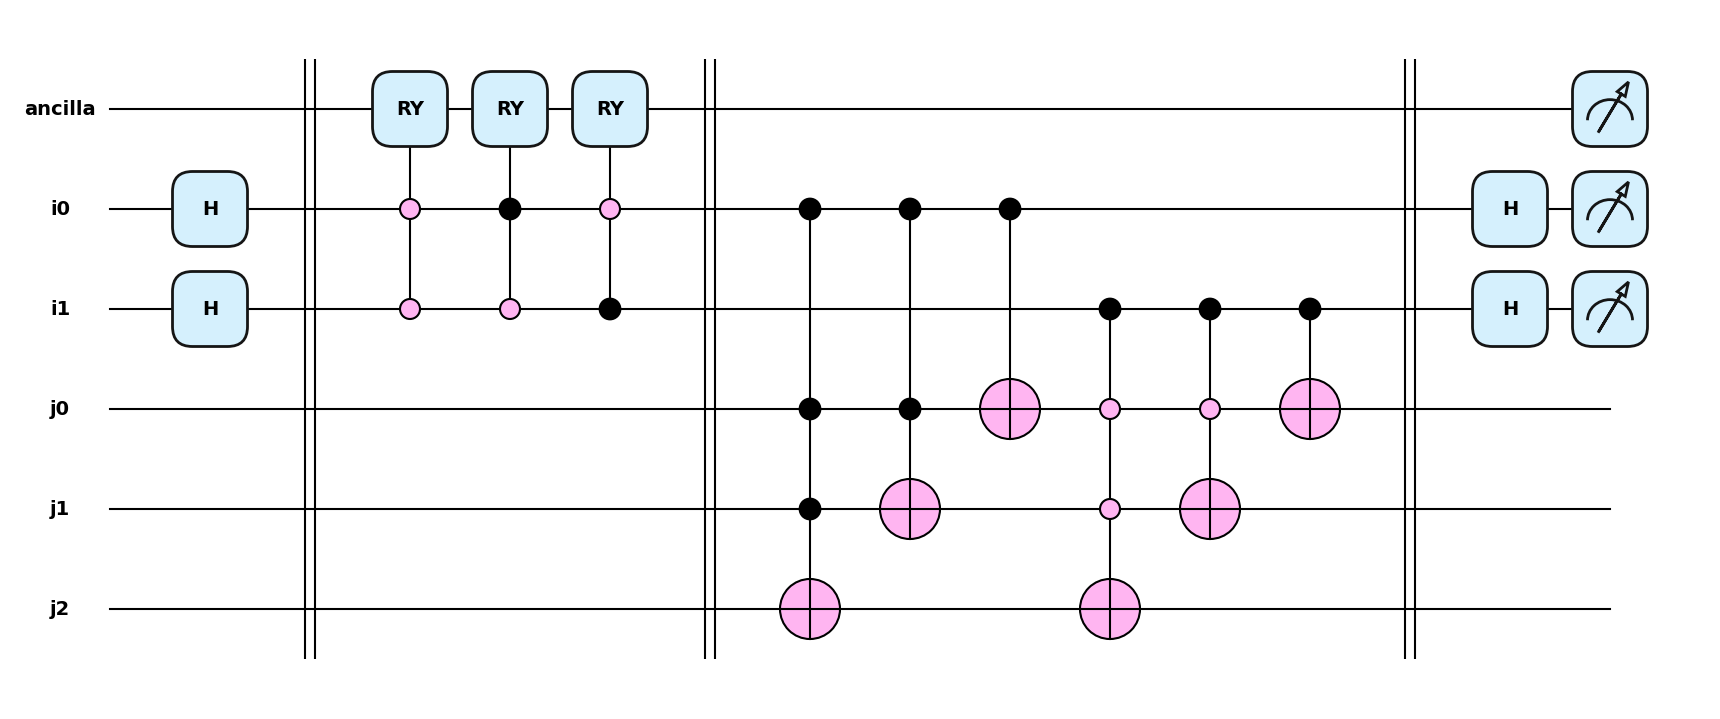

In [14]:
#We now construct our circuit to block encode the sparse matrix and draw it.

dev = qml.device("default.qubit", wires=(ancilla_wires + wires_i + wires_j))

@qml.qnode(dev)
def complete_circuit(thetas):
    HN(wires_i)
    qml.Barrier() # to separate the sections in the circuit
    UA(thetas, wires_i, ancilla_wires)
    qml.Barrier()
    UB(wires_i, wires_j)
    qml.Barrier()
    HN(wires_i)
    return qml.probs(wires=ancilla_wires + wires_i)

s = 4  # normalization constant
thetas = 2 * np.arccos(np.array([alpha - 1, beta, gamma]))

qml.draw_mpl(complete_circuit, style='pennylane')(thetas)
plt.show()

In [15]:
# Finally, we compute the matrix representation of the circuit and print its top-left block to compare it with the original matrix.

print(f"Original matrix:\n{A3}", "\n")
wire_order = ancilla_wires + wires_i[::-1] + wires_j[::-1]
U = qml.matrix(complete_circuit, wire_order=wire_order)(thetas).real
print(f"Full unitary:\n{U}","\n")
M = s * qml.matrix(complete_circuit, wire_order=wire_order)(thetas).real[0:len(A3),0:len(A3)]
print(f"Block-encoded submatrix multiplied by the normalization constant: \n{M}", "\n")

Original matrix:
[[0.1 0.3 0.  0.  0.  0.  0.  0.6]
 [0.6 0.1 0.3 0.  0.  0.  0.  0. ]
 [0.  0.6 0.1 0.3 0.  0.  0.  0. ]
 [0.  0.  0.6 0.1 0.3 0.  0.  0. ]
 [0.  0.  0.  0.6 0.1 0.3 0.  0. ]
 [0.  0.  0.  0.  0.6 0.1 0.3 0. ]
 [0.  0.  0.  0.  0.  0.6 0.1 0.3]
 [0.3 0.  0.  0.  0.  0.  0.6 0.1]] 

Full unitary:
[[ 0.025      0.075      0.        ...  0.         0.         0.2      ]
 [ 0.15       0.025      0.075     ...  0.         0.         0.       ]
 [ 0.         0.15       0.025     ...  0.         0.         0.       ]
 ...
 [ 0.         0.         0.        ...  0.025      0.075      0.       ]
 [ 0.         0.         0.        ...  0.15       0.025      0.075    ]
 [-0.2384848  0.         0.        ...  0.         0.15       0.025    ]] 

Block-encoded submatrix multiplied by the normalization constant: 
[[0.1 0.3 0.  0.  0.  0.  0.  0.6]
 [0.6 0.1 0.3 0.  0.  0.  0.  0. ]
 [0.  0.6 0.1 0.3 0.  0.  0.  0. ]
 [0.  0.  0.6 0.1 0.3 0.  0.  0. ]
 [0.  0.  0.  0.6 0.1 0.3 0.  0. 

Note that if we wanted to increase the dimension of A, then we need only to add more wires to the $j$ register in the device and in $U_B$.

---

## 1.3 Using `qml.BlockEncode` Approach

PennyLane provides a convenient operator that directly constructs a unitary \(U(A)\) such that the matrix \(A\) appears in the **top-left block** of the unitary.

Formally, the block-encoded unitary has the structure:

$$
U(A) =
\begin{bmatrix}
A & \sqrt{I - A^\dagger A} \\
\sqrt{I - A A^\dagger} & -A^\dagger
\end{bmatrix}.
$$

This construction ensures that, by projecting onto the ancilla subspace, one can recover the action of \(A\) from the larger unitary operator.


In [16]:
# Example matrix 4 (doesnt have to be Hermitian nor square for this method)

A4 = np.array([[0.1, 0.2, 0.7],
      [0.3, 0.4, 1.2]])   
print(f"Original matrix:\n{A4}", "\n")

dev = qml.device('default.qubit', wires=3)
@qml.qnode(dev)
def example_circuit():
    qml.BlockEncode(A4, wires=range(3)) 
    return qml.state()

U = qml.matrix(example_circuit)()
print(f"Full unitary:\n{np.round(U, 3)}","\n")

op = qml.BlockEncode(A4, wires=range(3))
alpha = op.hyperparameters["norm"]      # normalization used internally
print("alpha =", alpha,)

m, n = A4.shape
block = U[:m, :n]
M = alpha * block
print(f"Block-encoded submatrix multiplied by the normalization constant: \n{M}", "\n")



Original matrix:
[[0.1 0.2 0.7]
 [0.3 0.4 1.2]] 

Full unitary:
[[ 0.034  0.067  0.235  0.967 -0.057  0.     0.     0.   ]
 [ 0.101  0.134  0.403 -0.057  0.898  0.     0.     0.   ]
 [ 0.994 -0.008 -0.026 -0.034 -0.101  0.     0.     0.   ]
 [-0.008  0.988 -0.037 -0.067 -0.134  0.     0.     0.   ]
 [-0.026 -0.037  0.884 -0.235 -0.403  0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     1.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     1.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     1.   ]] 

alpha = 2.98
Block-encoded submatrix multiplied by the normalization constant: 
[[0.1 0.2 0.7]
 [0.3 0.4 1.2]] 



---
## 1.4 Manual Block Encoding with Qiskit Approach

Note that this same block-encoding construction can also be implemented *manually* in Qiskit. The idea is to embed a general matrix $A$ into a larger unitary matrix $U(A)$ such that $A$ appears in the top-left block.

1. **Normalize $A$:**  
   Compute the largest singular value $\alpha = \|A\|$ and define  
   $$
   A_{\text{norm}} = \frac{A}{\alpha},
   $$
   so that $\|A_{\text{norm}}\| \leq 1$.

2. **Construct the block-encoding unitary:**  
   Build a $4\times 4$ unitary (for a $2\times 2$ matrix $A$) in block
   form:
   $$
   U(A) =
   \begin{bmatrix}
   A_{\text{norm}} & \sqrt{I - A_{\text{norm}} A_{\text{norm}}^\dagger} \\
   \sqrt{I - A_{\text{norm}}^\dagger A_{\text{norm}}} & -A_{\text{norm}}^\dagger
   \end{bmatrix}.
   $$

3. **Simulate the action:**  
   - Start in $|0\rangle_{\text{ancilla}} \otimes |\psi\rangle_{\text{data}}$.
   - Apply $U(A)$.
   - Postselect (condition) on the ancilla qubit being $|0\rangle$.
   - The resulting data state is proportional to $(A/\alpha)|\psi\rangle$.



In [17]:
# Example matrix 5 (doesnt have to be Hermitian for this method)

A5 = np.array([[1, 2],
              [3, 4]], dtype=np.complex128)

print(f"Original matrix:\n{A5}", "\n")

# Compute normalization factor alpha (largest singular value)
_, s_vals, _ = svd(A5)
alpha = max(s_vals)
A_norm = A5 / alpha
print("alpha =", alpha)

# Build U(A) in block form
I2 = np.eye(2)
AA_dag = A_norm @ A_norm.conj().T
A_dagA = A_norm.conj().T @ A_norm

block_upper_right = sqrtm(I2 - AA_dag)
block_lower_left = sqrtm(I2 - A_dagA)

top = np.hstack([A_norm, block_upper_right])
bottom = np.hstack([block_lower_left, -A_norm.conj().T])
U = np.vstack([top, bottom])

print(f"\nFull unitary:\n{np.round(U, 3)}","\n")

def nearest_unitary(M):
    U, _, Vh = svd(M)
    return U @ Vh

U = nearest_unitary(U)

print(f"Full unitary (with approximate nearest unitary):\n{np.round(U, 3)}","\n")

m, n = A5.shape
block = U[:m, :n]
M = alpha * block
print(f"Block-encoded submatrix multiplied by the normalization constant: \n{np.round(M,3)}", "\n")

# Check unitarity U†U ≈ I
# print(np.round(U.conj().T @ U, 6))

# Represent as a Qiskit operator (2 qubits)
# U_op = Operator(U)
# Build circuit: 2 qubits (ancilla + data)
# qc = QuantumCircuit(2)
# qc.unitary(U_op, [0, 1]) # qubit 0 = ancilla, qubit 1 = data




Original matrix:
[[1.+0.j 2.+0.j]
 [3.+0.j 4.+0.j]] 

alpha = 5.464985704219043

Full unitary:
[[ 0.183+0.j  0.366+0.j  0.834+0.j -0.369+0.j]
 [ 0.549+0.j  0.732+0.j -0.369+0.j  0.163+0.j]
 [ 0.667+0.j -0.47 +0.j -0.183+0.j -0.549+0.j]
 [-0.47 +0.j  0.331+0.j -0.366+0.j -0.732+0.j]] 

Full unitary (with approximate nearest unitary):
[[ 0.183-0.j  0.366+0.j  0.834-0.j -0.369-0.j]
 [ 0.549-0.j  0.732-0.j -0.369-0.j  0.163-0.j]
 [ 0.667+0.j -0.47 +0.j -0.183-0.j -0.549+0.j]
 [-0.47 +0.j  0.331+0.j -0.366-0.j -0.732+0.j]] 

Block-encoded submatrix multiplied by the normalization constant: 
[[1.-0.j 2.+0.j]
 [3.-0.j 4.-0.j]] 

